# Fake News

## Import

In [1]:
import re
import time

import nltk
import pandas as pd
from matplotlib import pyplot as plt
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

nltk.download('punkt')  # for tokenization
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [2]:
df = pd.read_csv('../american_datasets/cleaned/2.csv', index_col=0)
df.head()

title  \
8476                        You Can Smell Hillary’s Fear   
10294  Watch The Exact Moment Paul Ryan Committed Pol...   
3608         Kerry to go to Paris in gesture of sympathy   
10142  Bernie supporters on Twitter erupt in anger ag...   
875     The Battle of New York: Why This Primary Matters   

                                                    text label  
8476   Daniel Greenfield, a Shillman Journalism Fello...  Fake  
10294  Google Pinterest Digg Linkedin Reddit Stumbleu...  Fake  
3608   U.S. Secretary of State John F. Kerry said Mon...  True  
10142  — Kaydee King (@KaydeeKing) November 9, 2016 T...  Fake  
875    It's primary day in New York and front-runners...  True

In [3]:
df.shape

(6335, 3)

## Visualization

(array([3164.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3171.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

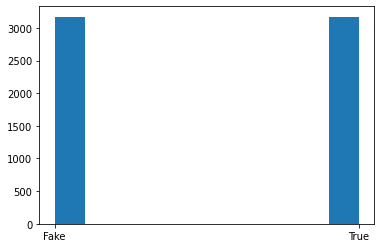

In [4]:
plt.hist(df['label'])

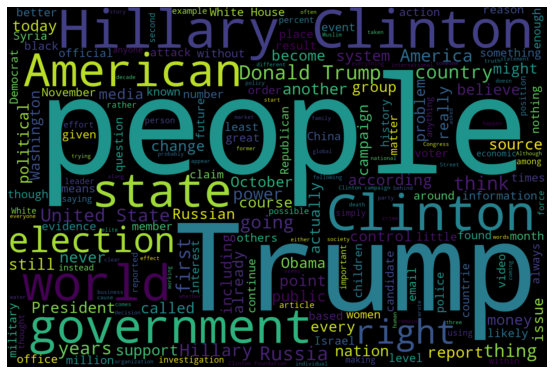

In [5]:
all_text = " ".join([str(txt) for txt in df[df['label'] == 'Fake']['text']])

wordcloud = WordCloud(min_word_length=5, width=1500, height=1000, background_color='black').generate(all_text)

fig = plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Preprocessing

### Remove junk

In [6]:
def clean(text):
    text = str(text)
    #all lowercase
    text = text.lower()

    # remove escape sequences
    text = re.sub(r'(\r\n|\n|\r|\t)', ' ', text)

    # remove urls
    text = re.sub(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ',
        text)

    # remove html
    text = re.sub(r'<.*?>', ' ', text)

    # remove emoj
    text = re.sub(r"["u"\U0001F600-\U0001F64F"  # emoticons
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", " ", text, flags=re.UNICODE)

    # remove all not alphanumeric character
    text = re.sub("[^a-z]+", " ", text)
    return text


df['title'] = [clean(title) for title in df['title']]
df['text'] = [clean(text) for text in df['text']]
df.head()

title  \
8476                        you can smell hillary s fear   
10294  watch the exact moment paul ryan committed pol...   
3608         kerry to go to paris in gesture of sympathy   
10142  bernie supporters on twitter erupt in anger ag...   
875      the battle of new york why this primary matters   

                                                    text label  
8476   daniel greenfield a shillman journalism fellow...  Fake  
10294  google pinterest digg linkedin reddit stumbleu...  Fake  
3608   u s secretary of state john f kerry said monda...  True  
10142   kaydee king kaydeeking november the lesson fr...  Fake  
875    it s primary day in new york and front runners...  True

### Remove stop words

In [7]:
stop_words = set(stopwords.words("english"))


def remove_stop_words(text):
    res = []
    for word in text.split():
        if word not in stop_words:
            res.append(word)
    return " ".join(res)


df['title'] = [remove_stop_words(title) for title in df['title']]
df['text'] = [remove_stop_words(text) for text in df['text']]
df.head()

title  \
8476                                  smell hillary fear   
10294  watch exact moment paul ryan committed politic...   
3608                     kerry go paris gesture sympathy   
10142  bernie supporters twitter erupt anger dnc trie...   
875                      battle new york primary matters   

                                                    text label  
8476   daniel greenfield shillman journalism fellow f...  Fake  
10294  google pinterest digg linkedin reddit stumbleu...  Fake  
3608   u secretary state john f kerry said monday sto...  True  
10142  kaydee king kaydeeking november lesson tonight...  Fake  
875    primary day new york front runners hillary cli...  True

### Stemming

In [8]:
snowball_stemmer = SnowballStemmer(language='english')


def stemmer(text):
    res = []
    for word in text.split():
        res.append(snowball_stemmer.stem(word))
    return " ".join(res)


df['title'] = [stemmer(title) for title in df['title']]
df['text'] = [stemmer(text) for text in df['text']]
df.head()

title  \
8476                                  smell hillari fear   
10294  watch exact moment paul ryan commit polit suic...   
3608                       kerri go pari gestur sympathi   
10142     berni support twitter erupt anger dnc tri warn   
875                        battl new york primari matter   

                                                    text label  
8476   daniel greenfield shillman journal fellow free...  Fake  
10294  googl pinterest digg linkedin reddit stumbleup...  Fake  
3608   u secretari state john f kerri said monday sto...  True  
10142  kayde king kaydeek novemb lesson tonight dem l...  Fake  
875    primari day new york front runner hillari clin...  True

## ML Model

In [9]:
def print_metrics(y_test, y_pred, training_time):
    print('0. Training time:', round(training_time), 's')
    print('1. Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('2. Precision:', round(precision_score(y_test, y_pred, average='macro'), 4))
    print('3. Recall:', round(recall_score(y_test, y_pred, average='macro'), 4))
    print('4. F1 score:', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('5. Confusion Matrix\n\n', pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

In [10]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
# pre processing
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
countVectorizer = CountVectorizer(min_df=2, max_df=0.7, ngram_range=(1, 2), tokenizer=token.tokenize)
tfidfTransformer = TfidfTransformer()

classifiers = [
    RandomForestClassifier(n_jobs=8),
    LogisticRegression(n_jobs=8),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(n_jobs=8)
]

#fit and prediction
for classifier in classifiers:
    start_time = time.time()
    
    print('---------------------------------')
    print(str(classifier))
    pipe = Pipeline(
        [
            ('vect', countVectorizer),
            ('tfidf', tfidfTransformer),
            ('classifier', classifier)
        ]
    )

    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    training_time = time.time() - start_time 
    print_metrics(y_test, y_pred, training_time)

---------------------------------
RandomForestClassifier(n_jobs=8)


0. Training time: 4 s
1. Accuracy: 0.8953
2. Precision: 0.8953
3. Recall: 0.8952
4. F1 score: 0.8953
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        875    97
True        102   827
---------------------------------
LogisticRegression(n_jobs=8)


0. Training time: 5 s
1. Accuracy: 0.9243
2. Precision: 0.9249
3. Recall: 0.9239
4. F1 score: 0.9241
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        915    57
True         87   842
---------------------------------
DecisionTreeClassifier()


0. Training time: 10 s
1. Accuracy: 0.8048
2. Precision: 0.8048
3. Recall: 0.8047
4. F1 score: 0.8047
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        788   184
True        187   742
---------------------------------
AdaBoostClassifier()


0. Training time: 12 s
1. Accuracy: 0.8617
2. Precision: 0.8616
3. Recall: 0.8618
4. F1 score: 0.8616
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        830   142
True        121   808
---------------------------------
KNeighborsClassifier(n_jobs=8)


0. Training time: 4 s
1. Accuracy: 0.5366
2. Precision: 0.7623
3. Recall: 0.5258
4. F1 score: 0.3932
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        972     0
True        881    48
